# Symbolic Regression and Classification

Symbolic Regression and Classification seek to optimize an interpretable algebraic equation. TPOT allows you to combine this approach with classical machine learning operations.

We can construct a search space for symbolic equations using either the TreePipeline or GraphSearchPipeline as neither have a fixed pipeline structure and instead optimize their own sequences and structure.

The strategy is to set the leaves to select a single feature (Using FSSNode), have all inner nodes be arithmetic operators, and have the root node be a classifier or regressor.

Note: This is still experimental. There are lots of opportunities to optimize the optimization process. In the future, symbolic regression/classification may have their own dedicated search space class.

In [1]:
import tpot
from tpot.search_spaces.pipelines import GraphSearchPipeline
from tpot.search_spaces.nodes import FSSNode
from tpot.config import get_search_space
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

/opt/anaconda3/envs/tpotenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Symbolic Classification

In [2]:
X, y = sklearn.datasets.make_classification(n_samples=1000, n_features=100, n_informative=6, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)

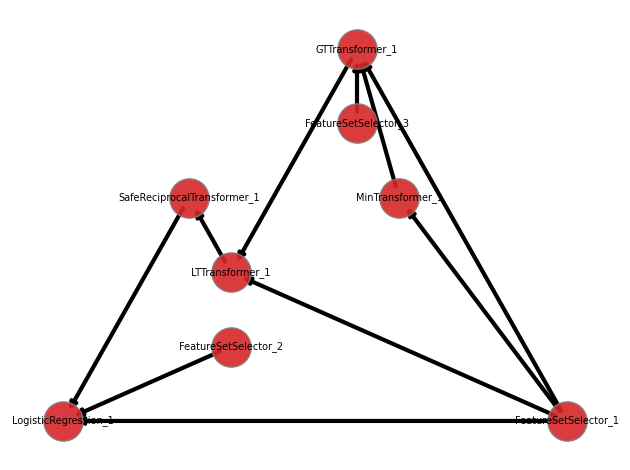

In [3]:
symbolic_classification_search_space = GraphSearchPipeline(
    root_search_space= get_search_space("LogisticRegression"),
    leaf_search_space = FSSNode(subsets=X_train.shape[1]), 
    inner_search_space = get_search_space(["arithmatic"]),
    max_size = 20,
)

#example pipelines randomly sampled
ind = symbolic_classification_search_space.generate(rng=5)
for i in range(3):
    ind.mutate(rng=1)
est_example = ind.export_pipeline()
est_example.plot()

Generation: 100%|██████████| 20/20 [00:40<00:00,  2.01s/it]


0.71168


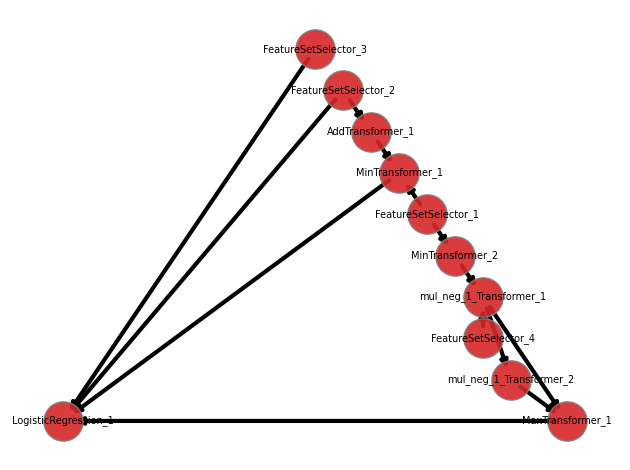

In [4]:
est = tpot.TPOTEstimator(  generations=20, 
                            max_time_mins=None,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            other_objective_functions=[tpot.objectives.number_of_nodes_objective],
                            other_objective_functions_weights=[-1],
                            n_jobs=32,
                            classification=True,
                            search_space = symbolic_classification_search_space,
                            verbose=1,
                            )

scorer = sklearn.metrics.get_scorer('roc_auc_ovo')

est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))
est.fitted_pipeline_.plot()

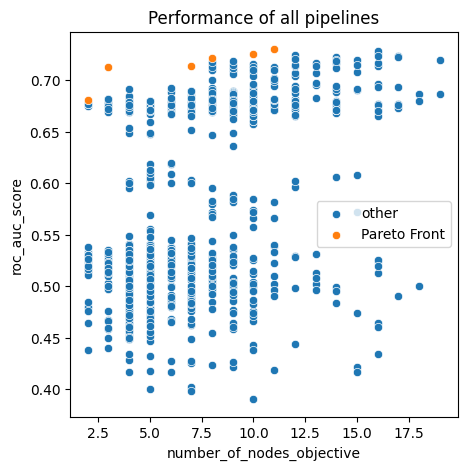

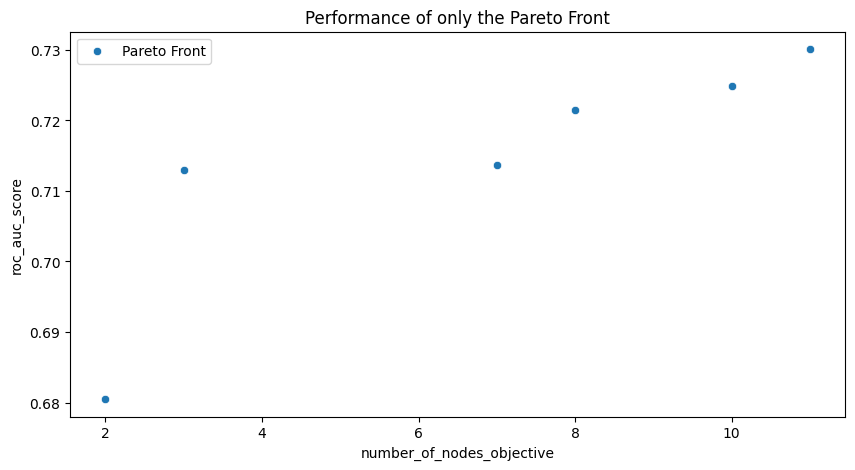

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
df = est.evaluated_individuals
#replace nans in pareto front with 0
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(df[df['Pareto_Front']!=1], y='roc_auc_score', x='number_of_nodes_objective', label='other', ax=ax)
sns.scatterplot(df[df['Pareto_Front']==1], y='roc_auc_score', x='number_of_nodes_objective', label='Pareto Front', ax=ax)
ax.title.set_text('Performance of all pipelines')
#log scale y
plt.show()

#replace nans in pareto front with 0
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(df[df['Pareto_Front']==1], y='roc_auc_score', x='number_of_nodes_objective', label='Pareto Front', ax=ax)
ax.title.set_text('Performance of only the Pareto Front')
#log scale y
# ax.set_yscale('log')
plt.show()

Symbolic Regression

Generation: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


-3073.9914754941187


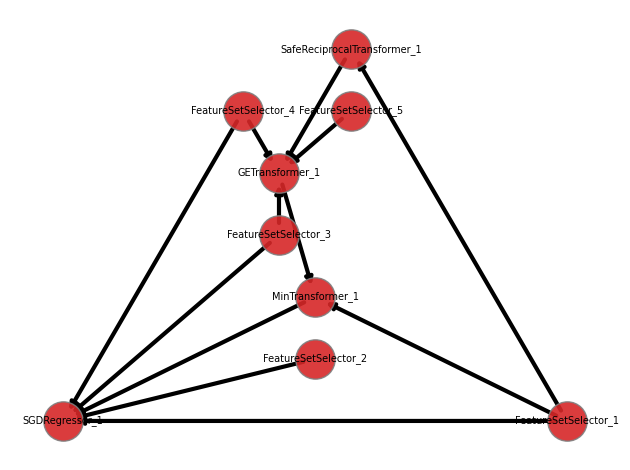

In [6]:
import tpot
import sklearn.datasets

scorer = sklearn.metrics.get_scorer('neg_mean_squared_error')
X, y = sklearn.datasets.load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)

graph_search_space = tpot.search_spaces.pipelines.GraphSearchPipeline(
    root_search_space= tpot.config.get_search_space("SGDRegressor"),
    leaf_search_space = tpot.search_spaces.nodes.FSSNode(subsets=X_train.shape[1]), 
    inner_search_space = tpot.config.get_search_space(["arithmatic"]),
    max_size = 10,
)

est = tpot.TPOTEstimator(  generations=20, 
                            max_time_mins=None,
                            scorers=['neg_mean_squared_error'],
                            scorers_weights=[1],
                            other_objective_functions=[tpot.objectives.number_of_nodes_objective],
                            other_objective_functions_weights=[-1],
                            n_jobs=32,
                            classification=False,
                            search_space = graph_search_space ,
                            verbose=2,
                            )



est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))
est.fitted_pipeline_.plot()

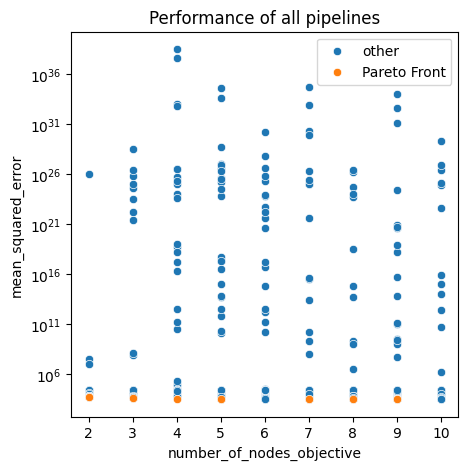

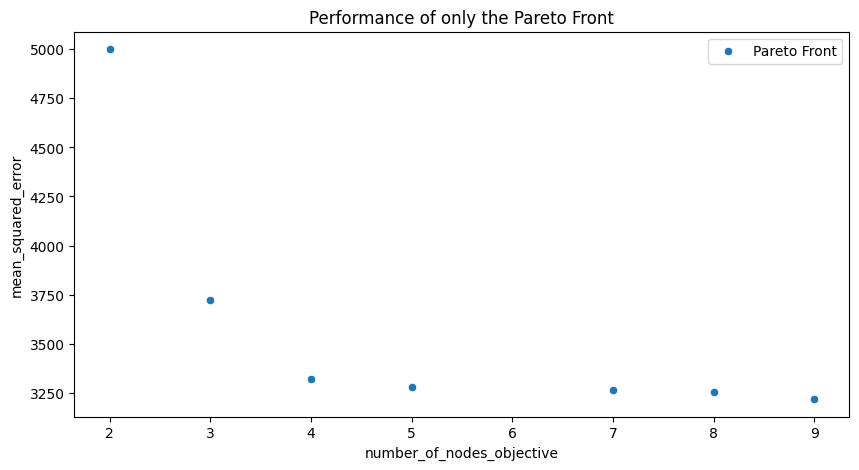

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
df = est.evaluated_individuals
df['mean_squared_error'] = -df['mean_squared_error']
#replace nans in pareto front with 0
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(df[df['Pareto_Front']!=1], y='mean_squared_error', x='number_of_nodes_objective', label='other', ax=ax)
sns.scatterplot(df[df['Pareto_Front']==1], y='mean_squared_error', x='number_of_nodes_objective', label='Pareto Front', ax=ax)
ax.title.set_text('Performance of all pipelines')
#log scale y
ax.set_yscale('log')
plt.show()

#replace nans in pareto front with 0
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(df[df['Pareto_Front']==1], y='mean_squared_error', x='number_of_nodes_objective', label='Pareto Front', ax=ax)
ax.title.set_text('Performance of only the Pareto Front')
#log scale y
# ax.set_yscale('log')
plt.show()